In [1]:
import os
import sys
import datacube
import numpy as np
import pandas as pd
import xarray as xr
from otps import TimePoint
from otps import predict_tide
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from datacube.utils import geometry
from datacube.utils.geometry import CRS
from datacube_stats.statistics import GeoMedian
from dateutil.relativedelta import relativedelta
from datacube.helpers import ga_pq_fuser
from datacube.storage import masking
from collections import defaultdict
import itertools

# Import external functions from dea-notebooks using relative link to Scripts
sys.path.append('/g/data/r78/rt1527/dea-notebooks/Scripts')
import DEAPlotting

# Create datacube instance
dc = datacube.Datacube(app='Tidal tagging')

def date_range(start_date, end_date, increment, period):
    
    """Generate dates seperated by given time increment/period"""
    
    result = []
    nxt = start_date
    delta = relativedelta(**{period:increment})
    while nxt <= end_date:
        result.append(nxt)
        nxt += delta
    return result


## Setup

In [3]:
# Set up analysis data query
lat, lon = -13.4225701889, 130.28851991

# Set a tide post: this is the location the OTPS model uses to compute tides for the supplied datetimes
tidepost_lat, tidepost_lon = -13.3079256385, 130.187740555

# Set tidal lims
lower_tideheight = 0.40
upper_tideheight = 0.60

# Set times
time_period = ('1988-01-01', '2018-01-01')
epoch_years = 5

# Set sensors
sensors = ['ls5', 'ls7', 'ls8']

## Analysis
Three sensors
X time periods

Filter by tide height
Filter by date

In [4]:
# For each epoch between start and end of timeperiod, create list of datetimes
start = datetime.strptime(time_period[0], "%Y-%m-%d")
end = datetime.strptime(time_period[1], "%Y-%m-%d")
epochs = date_range(start, end, epoch_years, 'years') 

# Set up query
x, y = geometry.point(lon, lat, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
query = {'x': (x - 5000, x + 5000),
         'y': (y - 5000, y + 5000),
         'time': time_period,
         'crs': 'EPSG:3577'}

# Output dicts to hold entire time-series for each sensor
sensor_dict = {}
pq_dict = {}

# For each sensor, dask load data and compute tide heights for each sensor
for sensor in sensors:
    
    # Return observations matching query without actually loading them using dask
    sensor_all = dc.load(product = '{}_nbart_albers'.format(sensor), 
                     group_by = 'solar_day', 
                     dask_chunks={'time': 1},
                     **query)

    # Load PQ data matching query without actually loading them using dask
    pq_all = dc.load(product = '{}_pq_albers'.format(sensor),
                    group_by = 'solar_day',
                    fuse_func=ga_pq_fuser, 
                    dask_chunks={'time': 1},
                    **query)

    # Keep only observations that have matching PQ data 
    time = (sensor_all.time - pq_all.time).time
    sensor_all = sensor_all.sel(time=time)
    pq_all = pq_all.sel(time=time)
    
    # Use the tidal mode to compute tide heights for each observation:
    obs_datetimes = sensor_all.time.data.astype('M8[s]').astype('O').tolist()
    obs_timepoints = [TimePoint(tidepost_lon, tidepost_lat, dt) for dt in obs_datetimes]
    obs_predictedtides = predict_tide(obs_timepoints)
    obs_tideheights = [predictedtide.tide_m for predictedtide in obs_predictedtides]

    # Assign these tide heights back into the dataset as a new variable
    sensor_all['tide_heights'] = xr.DataArray(obs_tideheights, [('time', sensor_all.time)])  
    
    # Append results for each sensor to a dictionary with sensor name as the key
    sensor_dict[sensor] = sensor_all
    pq_dict[sensor] = pq_all   

    
# Calculate max and min tide heights for the entire time series and all sensors
obs_min = np.min([sensor_ds.tide_heights.min() for sensor_ds in sensor_dict.values()])
obs_max = np.max([sensor_ds.tide_heights.max() for sensor_ds in sensor_dict.values()])
obs_range = obs_max - obs_min

# Calculate tidal limits used for subsequent data selection
sel_min = obs_min + (obs_range * lower_tideheight)
sel_max = obs_min + (obs_range * upper_tideheight)
print('Analysing tidal heights of {0:.2f} m to {1:.2f} m out of an observed local tidal ' 
      'range of {2:.2f} m to {3:.2f} m'.format(sel_min, sel_max, obs_min, obs_max))

In [14]:
sensor_epoch_dict = defaultdict(list)
pq_epoch_dict = defaultdict(list)
   
for epoch, sensor in itertools.product(epochs[:-1], sensor_dict.keys()):
                                           
    # Select dataset
    sensor_all = sensor_dict[sensor]  
    pq_all = pq_dict[sensor] 
                                           
    # Filter by tidal stage
    sensor_subset = sensor_all.where((sensor_all.tide_heights >= sel_min) &
                                     (sensor_all.tide_heights <= sel_max), drop = True)
    
    # Filter pq to same timesteps (this avoids conversion to float by `.where`)
    pq_subset = pq_all.sel(time = sensor_subset.time)

    # Identify from and to date strings
    from_date = epoch.strftime('%Y-%m-%d')
    to_date = (epoch + relativedelta(years=epoch_years)).strftime('%Y-%m-%d')
    
    # Subset sensor to from and to date for epoch
    print('Filtering from {} to {} for {}'.format(from_date, to_date, sensor))
    sensor_subset = sensor_subset.sel(time=slice(from_date, to_date))
    pq_subset = pq_subset.sel(time=slice(from_date, to_date))

    # Add subsetted data to dicts (one key matching a list of sensor data for each epoch)
    sensor_epoch_dict[from_date].append(sensor_subset)
    pq_epoch_dict[from_date].append(pq_subset)
    

Filtering from 1988-01-01 to 1993-01-01 for ls5
Filtering from 1988-01-01 to 1993-01-01 for ls7
Filtering from 1988-01-01 to 1993-01-01 for ls8
Filtering from 1993-01-01 to 1998-01-01 for ls5
Filtering from 1993-01-01 to 1998-01-01 for ls7
Filtering from 1993-01-01 to 1998-01-01 for ls8
Filtering from 1998-01-01 to 2003-01-01 for ls5
Filtering from 1998-01-01 to 2003-01-01 for ls7
Filtering from 1998-01-01 to 2003-01-01 for ls8
Filtering from 2003-01-01 to 2008-01-01 for ls5
Filtering from 2003-01-01 to 2008-01-01 for ls7
Filtering from 2003-01-01 to 2008-01-01 for ls8
Filtering from 2008-01-01 to 2013-01-01 for ls5
Filtering from 2008-01-01 to 2013-01-01 for ls7
Filtering from 2008-01-01 to 2013-01-01 for ls8
Filtering from 2013-01-01 to 2018-01-01 for ls5
Filtering from 2013-01-01 to 2018-01-01 for ls7
Filtering from 2013-01-01 to 2018-01-01 for ls8


ValueError: must supply at least one object to concatenate

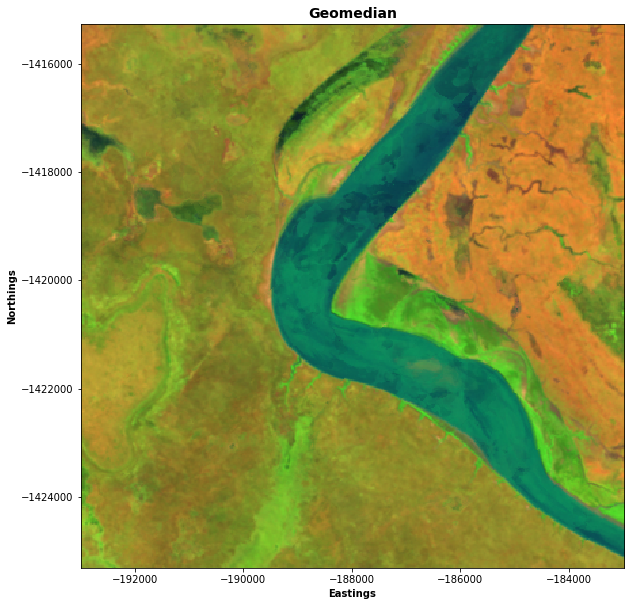

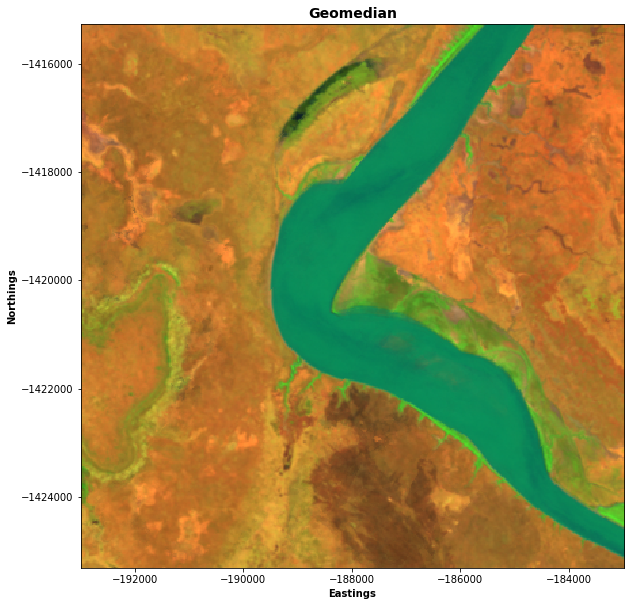

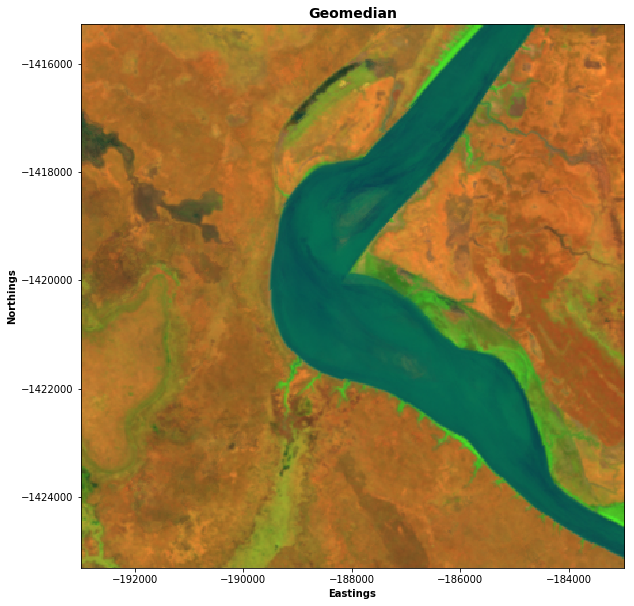

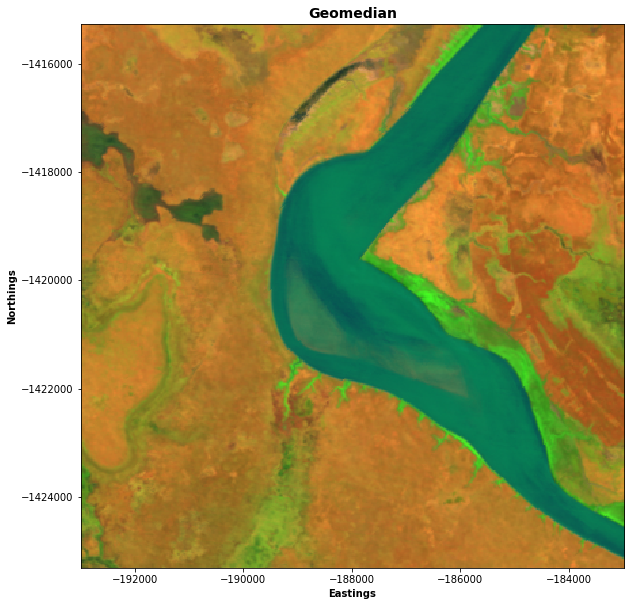

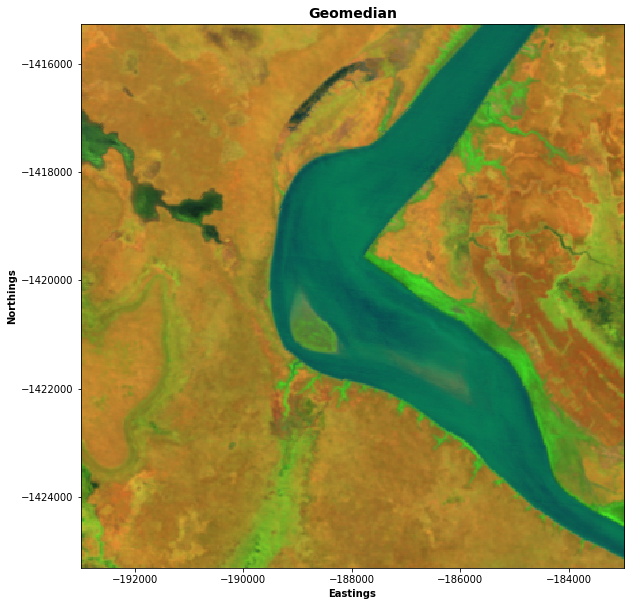

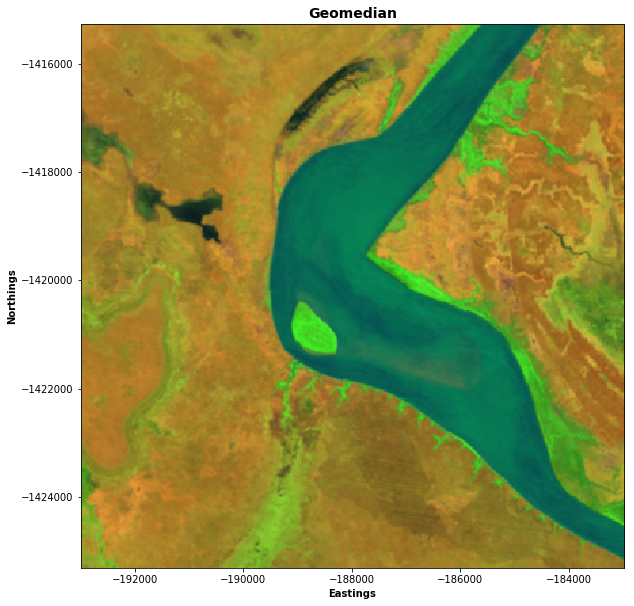

In [51]:
for from_date in sensor_epoch_dict.keys():
    
    # Concatenate all sensors for each epoch 
    print('Loading and combining data for {}'.format(from_date))
    sensor_combined = xr.concat([i.compute() for i in sensor_epoch_dict[from_date]], dim='time')
    pq_combined = xr.concat([i.compute() for i in pq_epoch_dict[from_date]], dim='time')
    
    # Manually add flag definition back in (it is lost during the concatenation)
    pq_combined.pixelquality.attrs['flags_definition'] = pq_all.pixelquality.flags_definition
    
    # Sort output datasets by date
    sensor_combined = sensor_combined.sortby('time')
    pq_combined = pq_combined.sortby('time')
    
    # Identify pixels with no clouds/shadows in either ACCA for Fmask
    good_quality = masking.make_mask(pq_combined.pixelquality,
                                     cloud_acca='no_cloud',
                                     cloud_shadow_acca='no_cloud_shadow',
                                     cloud_shadow_fmask='no_cloud_shadow',
                                     cloud_fmask='no_cloud',
                                     blue_saturated=False,
                                     green_saturated=False,
                                     red_saturated=False,
                                     nir_saturated=False,
                                     swir1_saturated=False,
                                     swir2_saturated=False,
                                     contiguous=True)
    
    # Apply mask to set all PQ-affected pixels to NaN
    sensor_combined = sensor_combined.where(good_quality)

    # Compute geomedian composite using all timesteps
    geomedian_ds = GeoMedian().compute(sensor_combined)
    
    # Plot output and save
    fig, ax = DEAPlotting.three_band_image(ds=geomedian_ds, bands=['swir1', 'nir', 'green'], 
                                           title = 'from_date', reflect_stand=4000)
    fig.savefig('output_{}.png'.format(from_date))
    